# 1. Data Collection

## Census Tract Data

In [2]:
import requests
import zipfile
import io
import os
import geopandas as gpd
from dotenv import load_dotenv
from census import Census
import pandas as pd
from shapely.geometry import Point
import osmnx as ox
from scipy.stats import entropy




In [ ]:
states = ["CA", "CO", "VT", "DC", "NY"]

In [ ]:


states = {
    "CA": "06",
    "CO": "08",
    "VT": "50",
    "DC": "11",
    "NY": "36"
}

base_url = "https://www2.census.gov/geo/tiger/TIGER2020/TRACT/"

output_dir = "data_raw/census_tracts"
os.makedirs(output_dir, exist_ok=True)

for state, fips in states.items():
    url = f"{base_url}tl_2020_{fips}_tract.zip"
    print(f"Downloading {state}...")
    
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(os.path.join(output_dir, state))


In [ ]:


tracts_ca = gpd.read_file("data_raw/census_tracts/CA")
tracts_ca.head()


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,029,004402,06029004402,44.02,Census Tract 44.02,G5020,S,1865739,0,+35.5917343,-119.3337642,"POLYGON ((-119.33828 35.58143, -119.33827 35.5..."
1,06,047,000802,06047000802,8.02,Census Tract 8.02,G5020,S,2321653,0,+37.3433591,-120.5854604,"POLYGON ((-120.59599 37.34121, -120.59596 37.3..."
2,06,085,501402,06085501402,5014.02,Census Tract 5014.02,G5020,S,522620,0,+37.3453341,-121.8665169,"POLYGON ((-121.87381 37.34412, -121.87361 37.3..."
3,06,005,000102,06005000102,1.02,Census Tract 1.02,G5020,S,456204155,7940832,+38.5496993,-120.2509786,"POLYGON ((-120.61016 38.4156, -120.61 38.41577..."
4,06,029,004901,06029004901,49.01,Census Tract 49.01,G5020,S,1459379,0,+35.7837173,-119.2462266,"POLYGON ((-119.25262 35.79043, -119.25259 35.7..."


In [ ]:
tracts_ca.crs


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [ ]:

states = ["CA", "CO", "VT", "DC", "NY"]

input_base = "data_raw/census_tracts"
output_dir = "data_processed/tracts_geojson"
os.makedirs(output_dir, exist_ok=True)

for state in states:
    print(f"Processing {state}...")
    
    gdf = gpd.read_file(os.path.join(input_base, state))
    
    # Ensure correct CRS
    gdf = gdf.to_crs(epsg=4326)
    
    # Keep only necessary columns (clean)
    gdf = gdf[["GEOID", "geometry"]]
    
    # Save as GeoJSON
    output_path = os.path.join(output_dir, f"tracts_{state}.geojson")
    gdf.to_file(output_path, driver="GeoJSON")


Processing CA...
Processing CO...
Processing VT...
Processing DC...
Processing NY...


Census tract boundaries were converted from ESRI Shapefile format to GeoJSON to ensure compatibility with web-based visualization tools and to simplify downstream spatial processing. All geometries were standardized to the WGS84 coordinate reference system (EPSG:4326), enabling seamless integration with interactive mapping frameworks.

In [ ]:
gdf = gpd.read_file("data_processed/tracts_geojson/tracts_CA.geojson")

print(gdf.crs)
print(gdf.columns)
print(len(gdf))


EPSG:4326
Index(['GEOID', 'geometry'], dtype='str')
9129


## Census Data

In [ ]:


# Load .env file
load_dotenv()

# Get API key
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

# Sanity check (should NOT print full key)
print("Census API key loaded:", CENSUS_API_KEY is not None)

# Initialize Census client
c = Census(CENSUS_API_KEY)

Census API key loaded: True


In [ ]:
states = {
    "CA": "06",
    "CO": "08",
    "VT": "50",
    "DC": "11",
    "NY": "36"
}

#selected columns

acs_vars = {
    "population": "B01003_001E",
    "households": "B11001_001E",
    "median_income": "B19013_001E",
    "workers": "B23025_002E",
    "mean_commute_time": "B08303_001E",
    "vehicles_total": "B08201_001E"
}


# Download ACS data

all_states = []

for state_name, state_fips in states.items():
    print(f"Downloading ACS data for {state_name}...")
    
    data = c.acs5.state_county_tract(
        fields=list(acs_vars.values()),
        state_fips=state_fips,
        county_fips=Census.ALL,
        tract=Census.ALL
    )
    
    df = pd.DataFrame(data)
    
    # Construct GEOID
    df["GEOID"] = df["state"] + df["county"] + df["tract"]
    
    # Rename variables
    df = df.rename(columns={v: k for k, v in acs_vars.items()})
    
    # Convert to numeric
    for col in acs_vars.keys():
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    df["state_code"] = state_name
    
    all_states.append(df)


# Combine all states
acs_df = pd.concat(all_states, ignore_index=True)


# Clean missing / sentinel values
acs_df.replace(-666666666, pd.NA, inplace=True)

# Save output

output_path = "data_processed/acs_demographics_tracts.csv"
os.makedirs("data_processed", exist_ok=True)
acs_df.to_csv(output_path, index=False)

print(f"\nACS data saved to: {output_path}")
print("Total census tracts:", len(acs_df))



ACS data saved to: data_processed/acs_demographics_tracts.csv
Total census tracts: 16371


In [ ]:
acs_df.head()

,population,households,median_income,workers,mean_commute_time,vehicles_total,state,county,tract,GEOID,state_code
0,3094.0,1316.0,250001.0,1650.0,918.0,1316.0,06,001,400100,06001400100,CA
1,2093.0,861.0,225880.0,1124.0,572.0,861.0,06,001,400200,06001400200,CA
2,5727.0,2713.0,157731.0,3662.0,2259.0,2713.0,06,001,400300,06001400300,CA
3,4395.0,1803.0,159612.0,2483.0,1420.0,1803.0,06,001,400400,06001400400,CA
4,3822.0,1655.0,96250.0,2327.0,1372.0,1655.0,06,001,400500,06001400500,CA


In [ ]:
acs_df.describe()


,population,households,workers,mean_commute_time,vehicles_total
count,16371.000000,16371.000000,16371.000000,16371.000000,16371.000000
mean,4041.293201,1466.053082,2096.152465,1623.120396,1466.053082
std,1787.142892,662.720656,1004.746846,794.049715,662.720656
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2811.500000,1023.000000,1422.500000,1090.000000,1023.000000
50%,3899.000000,1404.000000,2013.000000,1559.000000,1404.000000
75%,5083.500000,1844.500000,2666.000000,2077.000000,1844.500000
max,40481.000000,8336.000000,28566.000000,26056.000000,8336.000000


In [ ]:
acs_df.isna().mean()


population           0.000000
households           0.000000
median_income        0.022601
workers              0.000000
mean_commute_time    0.000000
vehicles_total       0.000000
state                0.000000
county               0.000000
tract                0.000000
GEOID                0.000000
state_code           0.000000
dtype: float64

Demographic and socioeconomic variables were obtained from the American Community Survey (ACS) 5-year estimates at the census tract level for five U.S. regions. Variables related to population, income, vehicle ownership, and commuting behavior were extracted and linked to spatial tract boundaries using the GEOID identifier.

## Lets do some basic cleaning before joing to spatial data

In [ ]:
numeric_cols = [
    "population",
    "households",
    "median_income",
    "workers",
    "mean_commute_time",
    "vehicles_total"
]

acs_df[numeric_cols] = acs_df[numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)

In [ ]:
acs_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 16371 entries, 0 to 16370
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   population         16371 non-null  float64
 1   households         16371 non-null  float64
 2   median_income      16001 non-null  float64
 3   workers            16371 non-null  float64
 4   mean_commute_time  16371 non-null  float64
 5   vehicles_total     16371 non-null  float64
 6   state              16371 non-null  str    
 7   county             16371 non-null  str    
 8   tract              16371 non-null  str    
 9   GEOID              16371 non-null  str    
 10  state_code         16371 non-null  str    
dtypes: float64(6), str(5)
memory usage: 1.4 MB


In [ ]:
acs_df.replace(-666666666, pd.NA, inplace=True)


,population,households,median_income,workers,mean_commute_time,vehicles_total,state,county,tract,GEOID,state_code
0,3094.0,1316.0,250001.0,1650.0,918.0,1316.0,06,001,400100,06001400100,CA
1,2093.0,861.0,225880.0,1124.0,572.0,861.0,06,001,400200,06001400200,CA
2,5727.0,2713.0,157731.0,3662.0,2259.0,2713.0,06,001,400300,06001400300,CA
3,4395.0,1803.0,159612.0,2483.0,1420.0,1803.0,06,001,400400,06001400400,CA
4,3822.0,1655.0,96250.0,2327.0,1372.0,1655.0,06,001,400500,06001400500,CA
...,...,...,...,...,...,...,...,...,...,...,...
16366,2907.0,1050.0,71250.0,1349.0,1149.0,1050.0,36,123,150301,36123150301,NY
16367,2066.0,849.0,58917.0,823.0,641.0,849.0,36,123,150302,36123150302,NY
16368,3798.0,1238.0,82917.0,1789.0,1466.0,1238.0,36,123,150400,36123150400,NY
16369,2040.0,954.0,68203.0,984.0,882.0,954.0,36,123,150501,36123150501,NY


In [ ]:
acs_df = acs_df.drop_duplicates(subset="GEOID")


In [ ]:
acs_df.describe()

,population,households,median_income,workers,mean_commute_time,vehicles_total
count,16371.000000,16371.000000,16001.000000,16371.000000,16371.000000,16371.000000
mean,4041.293201,1466.053082,99785.846135,2096.152465,1623.120396,1466.053082
std,1787.142892,662.720656,45875.778450,1004.746846,794.049715,662.720656
min,0.000000,0.000000,2499.000000,0.000000,0.000000,0.000000
25%,2811.500000,1023.000000,67171.000000,1422.500000,1090.000000,1023.000000
50%,3899.000000,1404.000000,90859.000000,2013.000000,1559.000000,1404.000000
75%,5083.500000,1844.500000,122708.000000,2666.000000,2077.000000,1844.500000
max,40481.000000,8336.000000,250001.000000,28566.000000,26056.000000,8336.000000


In [ ]:
acs_df.isna().mean()


population           0.000000
households           0.000000
median_income        0.022601
workers              0.000000
mean_commute_time    0.000000
vehicles_total       0.000000
state                0.000000
county               0.000000
tract                0.000000
GEOID                0.000000
state_code           0.000000
dtype: float64

# Tracts + ACS

In [ ]:
acs_df = pd.read_csv("data_processed/acs_demographics_tracts.csv", dtype={"GEOID": str})
tracts_dir = "data_processed/tracts_geojson"
output_dir = "data_processed/tracts_demographics"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
states = ["CA", "CO", "VT", "DC", "NY"]

for state in states:
    print(f"\nProcessing {state}...")
    
    # Load tract GeoJSON
    tracts = gpd.read_file(f"{tracts_dir}/tracts_{state}.geojson")
    
    # Filter ACS to this state
    acs_state = acs_df[acs_df["state_code"] == state].copy()
    
    # JOIN (left join keeps all tracts)
    tracts_joined = tracts.merge(
        acs_state,
        on="GEOID",
        how="left"
    )
    
    # Save output
    out_path = f"{output_dir}/tracts_{state}_demographics.geojson"
    tracts_joined.to_file(out_path, driver="GeoJSON")
    
    print(f"Saved: {out_path}")



Processing CA...
Saved: data_processed/tracts_demographics/tracts_CA_demographics.geojson

Processing CO...
Saved: data_processed/tracts_demographics/tracts_CO_demographics.geojson

Processing VT...
Saved: data_processed/tracts_demographics/tracts_VT_demographics.geojson

Processing DC...
Saved: data_processed/tracts_demographics/tracts_DC_demographics.geojson

Processing NY...
Saved: data_processed/tracts_demographics/tracts_NY_demographics.geojson


In [ ]:
print(len(tracts), len(tracts_joined))


5411 5411


In [ ]:
tracts_joined[[
    "population",
    "households",
    "median_income"
]].isna().mean()


population       0.002772
households       0.002772
median_income    0.042321
dtype: float64

In [ ]:
tracts_joined.sample(5)[["GEOID", "population", "median_income"]]


,GEOID,population,median_income
4720,36047090200,3886.0,42424.0
3827,36081000101,4600.0,128641.0
1108,36103146105,NaN,NaN
725,36077590900,2653.0,76250.0
2267,36117020700,3436.0,66746.0


Here, we can see the more number of missing value after joining the acs value with tracts, this is because some tract do not have population and made for special region.

“A small proportion of census tracts lacked ACS demographic estimates due to zero population or data suppression. These tracts were retained in the spatial dataset to preserve geographic completeness and handled appropriately during modeling.”

In [ ]:
tracts_joined["GEOID"].duplicated().sum()


np.int64(0)

## EV charging station data from NREL (AFDC)

In [ ]:
NREL_API_KEY = os.getenv("NREL_API_KEY")

print("NREL key loaded:", NREL_API_KEY is not None)

if NREL_API_KEY is None:
    raise ValueError("NREL_API_KEY not found in .env")

NREL key loaded: True


In [ ]:
url = "https://developer.nrel.gov/api/alt-fuel-stations/v1.json"

params = {
    "api_key": NREL_API_KEY,
    "fuel_type": "ELEC",
    "access": "public",
    "status": "E",          # operational
    "country": "US",
    "limit": "all"
}

response = requests.get(url, params=params)
data = response.json()

stations = pd.DataFrame(data["fuel_stations"])
print("Total stations downloaded:", len(stations))

Total stations downloaded: 77321


In [ ]:
states = ["CA", "CO", "VT", "DC", "NY"]
stations = stations[stations["state"].isin(states)].copy()

keep_cols = [
    "id",
    "station_name",
    "latitude",
    "longitude",
    "state",
    "city",
    "zip",
    "ev_level2_evse_num",
    "ev_dc_fast_num",
    "ev_network"
]

stations = stations[keep_cols]

In [ ]:
stations[["ev_level2_evse_num", "ev_dc_fast_num"]] = (
    stations[["ev_level2_evse_num", "ev_dc_fast_num"]]
    .fillna(0)
    .astype(int)
)

stations["total_ports"] = (
    stations["ev_level2_evse_num"] +
    stations["ev_dc_fast_num"]
)


In [ ]:
stations.sample(20)

,id,station_name,latitude,longitude,state,city,zip,ev_level2_evse_num,ev_dc_fast_num,ev_network,total_ports
48357,320146,Holiday Inn - Tesla Supercharger,40.578941,-122.359420,CA,Redding,96002,0,44,Tesla,44
34034,225319,Suites On Main Kelseyville,38.977703,-122.839417,CA,Kelseyville,95451,1,0,Blink Network,1
808,49938,Nissan of Queens,40.681060,-73.845540,NY,Ozone Park,11417,1,0,Non-Networked,1
19618,177842,ALAMEDA AMADOR 4K 002,37.657809,-122.093425,CA,Hayward,94544,2,0,ChargePoint Network,2
49562,324802,Enclave 50,42.980590,-73.859640,NY,Ballston Spa,12020,10,0,VIALYNK,10
76898,450161,Inkwell at Baseline,39.997019,-105.006925,CO,Broomfield,80023,3,0,Blink Network,3
74905,446169,City of Hermosa Beach,33.863840,-118.395610,CA,Hermosa Beach,90254,14,0,TURNONGREEN,14
28192,201628,FCRTA - Sanger,36.705450,-119.563400,CA,Sanger,93657,2,0,Electrify America,2
38985,252005,CONNEXTCARE PHC STATION 1-2,43.569443,-76.120385,NY,Pulaski,13142,2,0,ChargePoint Network,2
61319,372941,Hotel Canandaigua,42.873938,-77.260211,NY,Canandaigua,14424,10,0,CHARGESMART_EV,10


In [ ]:
geometry = [
    Point(xy) for xy in zip(stations["longitude"], stations["latitude"])
]

gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=geometry,
    crs="EPSG:4326"
)


In [ ]:
gdf_stations['state'].unique()

<StringArray>
['CA', 'VT', 'NY', 'CO', 'DC']
Length: 5, dtype: str

In [ ]:
output_dir = "data_raw/chargers"
os.makedirs(output_dir, exist_ok=True)

out_path = f"{output_dir}/ev_chargers_afdc.geojson"
gdf_stations.to_file(out_path, driver="GeoJSON")

print("Saved:", out_path)

Saved: data_raw/chargers/ev_chargers_afdc.geojson


In [ ]:
gdf_stations[["state", "total_ports"]].groupby("state").count()
# gdf_stations[["ev_level2_evse_num", "ev_dc_fast_num"]].sum()


,total_ports
state,
CA,18870
CO,2636
DC,315
NY,5048
VT,532


“Public electric vehicle charging station data were obtained from the U.S. Department of Energy’s Alternative Fuels Data Center (AFDC). Station locations and charger capacities were filtered to include only operational, publicly accessible electric charging stations and aggregated at the census tract level.”

## Spatial Join Charger and tracts

In [ ]:
### Loading Charger

chargers = gpd.read_file(
    "data_raw/chargers/ev_chargers_afdc.geojson"
)

# Normalize state codes
chargers["state"] = chargers["state"].str.strip().str.upper()

# Ensure CRS
chargers = chargers.to_crs(epsg=4326)

print("Total chargers:", len(chargers))

Total chargers: 27401


In [ ]:
states = ["CA", "CO", "VT", "DC", "NY"]

tracts_dir = "data_processed/tracts_demographics"
output_dir = "data_processed/tracts_with_chargers"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
joined_all = []

for state in states:
    print(f"\n=== {state} ===")
    
    # Load tracts fresh
    tracts = gpd.read_file(
        f"{tracts_dir}/tracts_{state}_demographics.geojson"
    ).to_crs(epsg=4326)
    
    # Filter chargers to state
    chargers_state = chargers[chargers["state"] == state].copy()
    print("Chargers in state:", len(chargers_state))
    
    # Spatial join
    joined = gpd.sjoin(
        chargers_state,
        tracts[["GEOID", "geometry"]],
        predicate="within",   # use "intersects" if needed
        how="left"
    )
    joined_all.append(joined)
    
    match_rate = joined["GEOID"].notna().mean()
    print("Match rate:", round(match_rate, 3))

joined_all = pd.concat(joined_all, ignore_index=True)

joined_all['state'].unique()



=== CA ===
Chargers in state: 18870
Match rate: 1.0

=== CO ===
Chargers in state: 2636
Match rate: 1.0

=== VT ===
Chargers in state: 532
Match rate: 1.0

=== DC ===
Chargers in state: 315
Match rate: 1.0

=== NY ===
Chargers in state: 5048
Match rate: 1.0


<StringArray>
['CA', 'CO', 'VT', 'DC', 'NY']
Length: 5, dtype: str

In [ ]:
joined_all.sample(10)

,id,station_name,latitude,longitude,state,city,zip,ev_level2_evse_num,ev_dc_fast_num,ev_network,total_ports,geometry,index_right,GEOID
25968,349012,MARKETPLACE CENTER STATION,43.081834,-77.637083,NY,Rochester,14623,2,0,ChargePoint Network,2,POINT (-77.63708 43.08183),2972.0,36055013104
1166,122398,Emeritus Vineyards - Tesla Destination,38.428535,-122.851653,CA,Sebastopol,95472,2,0,Tesla Destination,2,POINT (-122.85165 38.42854),3993.0,06097153601
20991,387262,105 105 EDGEVIEW 5,39.918987,-105.103836,CO,Broomfield,80021,2,0,ChargePoint Network,2,POINT (-105.10384 39.91899),726.0,08014031104
8796,207360,DC CITY HALL DCFC1,33.824709,-116.511722,CA,Palm Springs,92262,0,1,ChargePoint Network,1,POINT (-116.51172 33.82471),5000.0,06065044701
11936,275512,BIO-RAD 825: EV.5-EV.6,38.020379,-122.276391,CA,Hercules,94547,2,0,ChargePoint Network,2,POINT (-122.27639 38.02038),4462.0,06013392300
2439,159962,IRVINE CO OFC MC 690 03,37.437058,-121.922649,CA,Milpitas,95035,1,0,ChargePoint Network,1,POINT (-121.92265 37.43706),8235.0,06085504602
21761,223437,TWIN STATE FORD #1,44.429643,-72.017100,VT,Saint Johnsbury,05819,0,1,ChargePoint Network,1,POINT (-72.0171 44.42964),1.0,50005957400
2773,160550,CCSF - SFO SFO LOT C-2,37.615911,-122.385167,CA,South San Francisco,94128,2,0,ChargePoint Network,2,POINT (-122.38517 37.61591),4371.0,06081984300
13438,328513,"Burger King Capitola, CA - Tesla Supercharger",36.978645,-121.966003,CA,Capitola,95010,0,16,Tesla,16,POINT (-121.966 36.97864),9044.0,06087121702
22387,64706,Cliff's Elbow Room,40.948819,-72.582795,NY,Jamesport,11947,1,0,Non-Networked,1,POINT (-72.5828 40.94882),2840.0,36103169905


### Aggregate Charger Supply per Tract

In [ ]:
agg = (
    joined_all
    .groupby("GEOID")
    .agg(
        station_count=("id", "count"),
        total_ports=("total_ports", "sum"),
        l2_ports=("ev_level2_evse_num", "sum"),
        dcfc_ports=("ev_dc_fast_num", "sum")
    )
    .reset_index()
)

In [ ]:
agg.sample(10)

,GEOID,station_count,total_ports,l2_ports,dcfc_ports
3622,06111002700,4,20,4,16
3140,06085502500,2,3,3,0
4038,08041000302,3,6,6,0
1787,06059011401,29,54,54,0
1510,06037800335,18,29,29,0
440,06029003307,5,29,2,27
2170,06065044605,1,2,2,0
633,06037128801,4,24,24,0
6030,36119007700,2,12,8,4
5967,36113072002,2,4,4,0


### Merge Aggregates Back to Tracts

In [ ]:
all_tracts = []

for state in states:
    print(f"\n=== {state} ===")

    tracts = gpd.read_file(
        f"{tracts_dir}/tracts_{state}_demographics.geojson"
    ).to_crs(epsg=4326)

    # optional: add state column if not already present
    tracts["state"] = state

    all_tracts.append(tracts)

# merge all states into one GeoDataFrame
final_tracts = gpd.GeoDataFrame(
    pd.concat(all_tracts, ignore_index=True),
    crs="EPSG:4326"
)


=== CA ===

=== CO ===

=== VT ===

=== DC ===

=== NY ===


In [ ]:
tracts_final = final_tracts.merge(
    agg,
    on="GEOID",
    how="left"
)

# Fill supply NaNs with 0
supply_cols = ["station_count", "total_ports", "l2_ports", "dcfc_ports"]
tracts_final[supply_cols] = (
    tracts_final[supply_cols]
    .fillna(0)
    .astype(int)
)


In [ ]:
tracts_final['state_code'].unique()

<StringArray>
['CA', 'CO', 'VT', 'DC', 'NY', nan]
Length: 6, dtype: str

### Saving the output

In [ ]:
out_path = f"{output_dir}/tracts_all_state_chargers.geojson"
tracts_final.to_file(out_path, driver="GeoJSON")

print("Saved:", out_path)


Saved: data_processed/tracts_with_chargers/tracts_all_state_chargers.geojson


# Distance Accessibility

### Loading Tracts

In [ ]:
tracts_all = gpd.read_file(
    "data_processed/tracts_with_chargers/tracts_all_state_chargers.geojson"
)

# Normalize state codes
tracts_all["state_code"] = tracts_all["state_code"].str.strip().str.upper()

Loading charger stations

In [ ]:
chargers = gpd.read_file(
    "data_raw/chargers/ev_chargers_afdc.geojson"
)

chargers["state"] = chargers["state"].str.strip().str.upper()


In [ ]:
tracts_all = tracts_all.to_crs(epsg=4326)
chargers = chargers.to_crs(epsg=4326)


In [ ]:
states = ["CA", "CO", "VT", "DC", "NY"]

out_dir = "data_processed/tracts_with_distance"
os.makedirs(out_dir, exist_ok=True)


In [ ]:
for state in states:
    print(f"\nProcessing distance features for {state}...")
    
    # ---------------------------
    # Filter tracts & chargers
    # ---------------------------
    tracts = tracts_all[tracts_all["state_code"] == state].copy()
    chargers_state = chargers[chargers["state"] == state].copy()
    chargers_dcfc = chargers_state[chargers_state["ev_dc_fast_num"] > 0]
    
    print("Tracts:", len(tracts))
    print("Chargers:", len(chargers_state))
    
    # ---------------------------
    # Create centroids
    # ---------------------------
    tracts["centroid"] = tracts.geometry.centroid
    tracts_centroids = tracts.set_geometry("centroid")
    
    # ---------------------------
    # Project to meters (CRITICAL)
    # ---------------------------
    tracts_centroids = tracts_centroids.to_crs(epsg=5070)
    chargers_state = chargers_state.to_crs(epsg=5070)
    chargers_dcfc = chargers_dcfc.to_crs(epsg=5070)
    
    # ---------------------------
    # Distance calculations
    # ---------------------------
    tracts_centroids["dist_nearest_charger_km"] = (
        tracts_centroids.geometry.apply(
            lambda g: chargers_state.distance(g).min()
        ) / 1000
    )
    
    tracts_centroids["dist_nearest_dcfc_km"] = (
        tracts_centroids.geometry.apply(
            lambda g: chargers_dcfc.distance(g).min()
            if len(chargers_dcfc) > 0 else np.nan
        ) / 1000
    )
    
    # ---------------------------
    # Merge back to polygons
    # ---------------------------
    tracts["dist_nearest_charger_km"] = (
        tracts_centroids["dist_nearest_charger_km"].values
    )
    
    tracts["dist_nearest_dcfc_km"] = (
        tracts_centroids["dist_nearest_dcfc_km"].values
    )
    
    # ---------------------------
    # Save state-wise output
    # ---------------------------
    if "centroid" in tracts.columns:
        tracts = tracts.drop(columns=["centroid"])

# Ensure polygon geometry is active
    tracts = tracts.set_geometry("geometry")

    out_path = f"{out_dir}/tracts_{state}_distance.geojson"
    tracts.to_file(out_path, driver="GeoJSON")
    
    print("Saved:", out_path)



Processing distance features for CA...
Tracts: 9129
Chargers: 18870


/var/folders/bq/hl2d1mzx4ln4s9vk722gsfv80000gn/T/ipykernel_1187/391168146.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tracts["centroid"] = tracts.geometry.centroid


Saved: data_processed/tracts_with_distance/tracts_CA_distance.geojson

Processing distance features for CO...
Tracts: 1447
Chargers: 2636


/var/folders/bq/hl2d1mzx4ln4s9vk722gsfv80000gn/T/ipykernel_1187/391168146.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tracts["centroid"] = tracts.geometry.centroid


Saved: data_processed/tracts_with_distance/tracts_CO_distance.geojson

Processing distance features for VT...
Tracts: 193
Chargers: 532


/var/folders/bq/hl2d1mzx4ln4s9vk722gsfv80000gn/T/ipykernel_1187/391168146.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tracts["centroid"] = tracts.geometry.centroid


Saved: data_processed/tracts_with_distance/tracts_VT_distance.geojson

Processing distance features for DC...
Tracts: 206
Chargers: 315


/var/folders/bq/hl2d1mzx4ln4s9vk722gsfv80000gn/T/ipykernel_1187/391168146.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tracts["centroid"] = tracts.geometry.centroid


Saved: data_processed/tracts_with_distance/tracts_DC_distance.geojson

Processing distance features for NY...
Tracts: 5396
Chargers: 5048


/var/folders/bq/hl2d1mzx4ln4s9vk722gsfv80000gn/T/ipykernel_1187/391168146.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tracts["centroid"] = tracts.geometry.centroid


Saved: data_processed/tracts_with_distance/tracts_NY_distance.geojson


In [ ]:
gdf = gpd.read_file("data_processed/tracts_with_distance/tracts_CA_distance.geojson")

gdf[[
    "dist_nearest_charger_km",
    "dist_nearest_dcfc_km"
]].describe()

,dist_nearest_charger_km,dist_nearest_dcfc_km
count,9129.000000,9129.000000
mean,2.019735,3.165211
std,4.080265,5.260918
min,0.001609,0.019433
25%,0.563967,1.022578
50%,1.035470,1.758605
75%,1.841556,2.992434
max,104.113030,105.093871


In [ ]:
(tracts["dist_nearest_dcfc_km"] >= tracts["dist_nearest_charger_km"]).mean()


np.float64(1.0)

# Land Build using Census CBP

### Download ZBP 2023
Due to the unavailability of tract-level CBP data, ZIP Code Business Patterns were used and allocated to census tracts using spatial correspondence.

In [4]:
ZBP_YEAR = "2023"

ZBP_URL = (
    "https://www2.census.gov/programs-surveys/"
    "cbp/datasets/2023/zbp23detail.zip"
)

raw_dir = "data_raw/zbp"
os.makedirs(raw_dir, exist_ok=True)

zip_path = f"{raw_dir}/zbp23detail.zip"

if not os.path.exists(zip_path):
    print("Downloading ZBP 2023...")
    r = requests.get(ZBP_URL)
    r.raise_for_status()
    with open(zip_path, "wb") as f:
        f.write(r.content)
else:
    print("ZBP ZIP already exists")


Extract ZBP ZIP

In [5]:
csv_path = f"{raw_dir}/zbp23detail.csv"

if not os.path.exists(csv_path):
    print("Extracting ZBP ZIP...")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(raw_dir)
else:
    print("ZBP CSV already extracted")


Extracting ZBP ZIP...


In [8]:
zbp = pd.read_csv(
    f"{raw_dir}/zbp23detail.txt",   # e.g., "zbp22detail.txt"
    dtype={
        "zip": str,
        "naics": str
    }
)

print("Total ZBP rows:", len(zbp))


Total ZBP rows: 2974116


In [12]:
with open("data_raw/zbp/zbp23detail.txt", "r") as f:
    print(f.readline())


"zip","name","naics","est","n<5","n5_9","n10_19","n20_49","n50_99","n100_249","n250_499","n500_999","n1000","city","stabbr","cty_name"



In [11]:
zbp.head(20)

,zip,name,naics,est,n<5,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,city,stabbr,cty_name
0,00501,"HOLTSVILLE, NY",------,5,5,N,N,N,N,N,N,N,N,HOLTSVILLE,NY,SUFFOLK
1,01001,"AGAWAM, MA",------,460,217,79,73,53,24,13,N,N,N,AGAWAM,MA,HAMPDEN
2,01001,"AGAWAM, MA",22----,3,N,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN
3,01001,"AGAWAM, MA",221///,3,N,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN
4,01001,"AGAWAM, MA",23----,49,32,8,3,3,N,N,N,N,N,AGAWAM,MA,HAMPDEN
5,01001,"AGAWAM, MA",236///,7,6,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN
6,01001,"AGAWAM, MA",2361//,7,6,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN
7,01001,"AGAWAM, MA",23611/,7,6,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN
8,01001,"AGAWAM, MA",236118,6,5,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN
9,01001,"AGAWAM, MA",237///,3,N,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN


In [13]:
zbp = zbp[zbp["naics"] != "------"].copy()


In [15]:
# Total establishments per ZIP
zbp_total = (
    zbp.groupby("zip")
    .agg(establishments_total=("est", "sum"))
    .reset_index()
)

# Retail (44–45)
zbp_retail = (
    zbp[zbp["naics"].str.startswith(("44", "45"))]
    .groupby("zip")
    .agg(retail_establishments=("est", "sum"))
    .reset_index()
)

# Food services (72)
zbp_food = (
    zbp[zbp["naics"].str.startswith("72")]
    .groupby("zip")
    .agg(food_establishments=("est", "sum"))
    .reset_index()
)

# Services (54, 81)
zbp_services = (
    zbp[zbp["naics"].str.startswith(("54", "81"))]
    .groupby("zip")
    .agg(service_establishments=("est", "sum"))
    .reset_index()
)

zbp_features = (
    zbp_total
    .merge(zbp_retail, on="zip", how="left")
    .merge(zbp_food, on="zip", how="left")
    .merge(zbp_services, on="zip", how="left")
    .fillna(0)
)


In [16]:
zbp_features.head()

,zip,establishments_total,retail_establishments,food_establishments,service_establishments
0,01001,1840,295.0,179.0,313.0
1,01002,2188,255.0,373.0,585.0
2,01003,40,0.0,0.0,34.0
3,01005,306,46.0,42.0,50.0
4,01007,796,53.0,80.0,183.0


Download ZCTA Shapefile

In [19]:
zcta_url = "https://www2.census.gov/geo/tiger/TIGER2020/ZCTA5/tl_2020_us_zcta510.zip"

raw_dir = "data_raw/zcta"
os.makedirs(raw_dir, exist_ok=True)

zip_path = f"{raw_dir}/zcta2020.zip"

if not os.path.exists(zip_path):
    print("Downloading ZCTA shapefile...")
    r = requests.get(zcta_url)
    r.raise_for_status()
    with open(zip_path, "wb") as f:
        f.write(r.content)
else:
    print("ZCTA ZIP already exists")


In [20]:
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(raw_dir)

print("ZCTA shapefile extracted")


ZCTA shapefile extracted


In [21]:
zcta = gpd.read_file(raw_dir).to_crs(epsg=5070)
zcta["zip"] = zcta["ZCTA5CE10"]


In [25]:
states = ["CA", "CO", "VT", "DC", "NY"]

tracts_list = []
for state in states:
    gdf = gpd.read_file(
        f"data_processed/tracts_with_distance/tracts_{state}_distance.geojson"
    )
    tracts_list.append(gdf)

tracts_all = gpd.GeoDataFrame(
    pd.concat(tracts_list, ignore_index=True),
    crs=tracts_list[0].crs
).to_crs(epsg=5070)


In [26]:
# Spatial intersection
intersection = gpd.overlay(
    zcta[["zip", "geometry"]],
    tracts_all[["GEOID", "geometry"]],
    how="intersection"
)

# Compute area weights
intersection["area"] = intersection.geometry.area

total_area = (
    intersection.groupby("zip")["area"]
    .sum()
    .reset_index(name="zip_area")
)

intersection = intersection.merge(total_area, on="zip")
intersection["weight"] = intersection["area"] / intersection["zip_area"]


/Users/sanjeebadhikari/miniconda3/envs/ev_gap_env/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 107035 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [27]:
zbp_alloc = zbp_features.merge(
    intersection[["zip", "GEOID", "weight"]],
    on="zip",
    how="left"
)

feature_cols = [
    "establishments_total",
    "retail_establishments",
    "food_establishments",
    "service_establishments"
]

for col in feature_cols:
    zbp_alloc[col] = zbp_alloc[col] * zbp_alloc["weight"]


In [28]:
tract_zbp = (
    zbp_alloc
    .groupby("GEOID")[feature_cols]
    .sum()
    .reset_index()
)


In [29]:
states = ["CA", "CO", "VT", "DC", "NY"]
out_dir = "data_processed/tracts_with_zbp"
os.makedirs(out_dir, exist_ok=True)

for state in states:
    print(f"\nMerging ZBP for {state}")
    
    tracts = gpd.read_file(
        f"data_processed/tracts_with_distance/tracts_{state}_distance.geojson"
    )
    
    tracts = tracts.merge(
        tract_zbp,
        on="GEOID",
        how="left"
    )
    
    tracts[feature_cols] = tracts[feature_cols].fillna(0)
    
    tracts.to_file(
        f"{out_dir}/tracts_{state}_zbp.geojson",
        driver="GeoJSON"
    )



Merging ZBP for CA

Merging ZBP for CO

Merging ZBP for VT

Merging ZBP for DC

Merging ZBP for NY


# Checking the final Dataset

In [30]:
tracts = gpd.read_file(
    "data_processed/tracts_with_zbp/tracts_CA_zbp.geojson"
)

tracts["GEOID"].head(), tracts["GEOID"].str.len().value_counts()


(0    06029004402
 1    06047000802
 2    06085501402
 3    06005000102
 4    06029004901
 Name: GEOID, dtype: str,
 GEOID
 11    9129
 Name: count, dtype: int64)

In [31]:
tracts.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
tracts[[
    "establishments_total",
    "retail_establishments",
    "food_establishments",
    "service_establishments"
]].isna().mean()


establishments_total      0.0
retail_establishments     0.0
food_establishments       0.0
service_establishments    0.0
dtype: float64

In [33]:
(tracts["establishments_total"] == 0).mean()


np.float64(0.0004381640924526235)

In [34]:
tracts["establishments_total"].sum()


np.float64(4621286.0)

In [35]:
tracts.shape[0], tracts["GEOID"].nunique()


(9129, 9129)

In [36]:
(tracts[[
    "establishments_total",
    "retail_establishments",
    "food_establishments",
    "service_establishments"
]] < 0).any()

establishments_total      False
retail_establishments     False
food_establishments       False
service_establishments    False
dtype: bool

In [37]:
tracts[[
    "population",
    "median_income",
    "dist_nearest_charger_km",
    "establishments_total",
    "retail_establishments",
    "food_establishments"
]].describe()

,population,median_income,dist_nearest_charger_km,establishments_total,retail_establishments,food_establishments
count,9129.000000,9003.000000,9129.000000,9129.000000,9129.000000,9129.000000
mean,4298.694819,104103.659225,2.019735,506.220397,50.314054,51.527002
std,1756.512472,47057.778485,4.080265,799.931382,79.371091,77.286447
min,0.000000,7000.000000,0.001609,0.000000,0.000000,0.000000
25%,3121.000000,70335.500000,0.563967,127.438714,12.776633,13.927151
50%,4151.000000,94917.000000,1.035470,279.737201,28.590300,30.823571
75%,5329.000000,127430.500000,1.841556,568.784006,56.759667,60.858416
max,40481.000000,250001.000000,104.113030,16627.549739,1556.755546,1722.509456


In [38]:
tracts[[
    "population",
    "establishments_total",
    "dist_nearest_charger_km"
]].corr()

,population,establishments_total,dist_nearest_charger_km
population,1.000000,0.063486,-0.096907
establishments_total,0.063486,1.000000,0.128562
dist_nearest_charger_km,-0.096907,0.128562,1.000000


<Axes: >

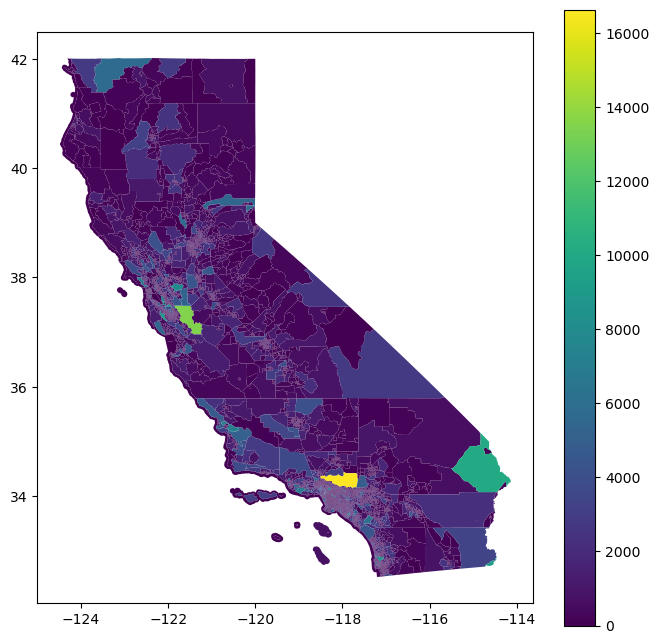

In [39]:
tracts.plot(
    column="establishments_total",
    figsize=(8,8),
    legend=True
)

Merging all data

In [40]:
states = ["CA", "CO", "VT", "DC", "NY"]

gdf_list = []

for state in states:
    print(f"Loading {state}...")
    
    gdf = gpd.read_file(
        f"data_processed/tracts_with_zbp/tracts_{state}_zbp.geojson"
    )
    
    gdf["state"] = state  # keep track of origin
    gdf_list.append(gdf)

# Combine
all_states = gpd.GeoDataFrame(
    pd.concat(gdf_list, ignore_index=True),
    crs=gdf_list[0].crs
)

print("Total tracts:", len(all_states))


Loading CA...
Loading CO...
Loading VT...
Loading DC...
Loading NY...
Total tracts: 16371


In [41]:
all_states["GEOID"].nunique(), len(all_states)


(16371, 16371)

In [42]:
all_states["state"].value_counts()


state
CA    9129
NY    5396
CO    1447
DC     206
VT     193
Name: count, dtype: int64

In [43]:
out_dir = "data_processed/final_combined"
os.makedirs(out_dir, exist_ok=True)

all_states.to_file(
    f"{out_dir}/all_states_tracts.geojson",
    driver="GeoJSON"
)

print("Saved combined GeoJSON")


Saved combined GeoJSON


In [44]:
model_df = all_states.drop(columns="geometry")

model_df.to_csv(
    f"{out_dir}/all_states_final_model_table.csv",
    index=False
)

print("Saved modeling table CSV")


Saved modeling table CSV
